<a href="https://colab.research.google.com/github/cartman12/DS-Unit-2-Classification-1/blob/master/module2-decision-trees/Mohamad%20ali%20Nasser%20-%20%20Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install category_encoders
!pip install pandas==0.23.4
!pip install graphviz
!apt-get install graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [0]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
pd.set_option('display.float_format', '{:.2f}'.format)

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv('https://drive.google.com/uc?export=download&id=14ULvX0uOgftTB2s97uS8lIx1nHGQIB0P'), 
                 pd.read_csv('https://drive.google.com/uc?export=download&id=1r441wLr7gKGHGLyPpKauvCuUOU556S2f'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv('https://drive.google.com/uc?export=download&id=1wvsYl9hbRbZuIuoaLWCsW_kbcxCdocHz')
sample_submission = pd.read_csv('https://drive.google.com/uc?export=download&id=1kfJewnmhowpUo381oSn3XqsQ6Eto23XV')

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

# Print dataframe shapes
print('train', train.shape)
print('val', val.shape)
print('test', test.shape)

train (47520, 41)
val (11880, 41)
test (14358, 40)


In [0]:
def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace them with the column mean.
    cols_with_zeros = ['construction_year', 'longitude', 'latitude']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col] = X[col].fillna(X[col].mean())
        
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract year from date_recorded
    X['year_recorded'] = X['date_recorded'].dt.year
    
    # quantity & quantity_group are duplicates, so drop one
    X = X.drop(columns='quantity_group')
    
    # for categoricals with missing values, fill with the category 'MISSING'
    categoricals = X.select_dtypes(exclude='number').columns
    for col in categoricals:
        X[col] = X[col].fillna('MISSING')
    
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [58]:
categorical_features = ['basin',
 'region',
 'public_meeting',
 'recorded_by',
 'scheme_management',
 'permit',
 'extraction_type',
 'management',
 'payment',
 'water_quality',
 'quantity',
 'source_type',
 'waterpoint_type']

['basin',
 'region',
 'public_meeting',
 'recorded_by',
 'scheme_management',
 'permit',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'payment_type',
 'water_quality',
 'quality_group',
 'quantity',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group']

In [0]:
categorical_features = ['public_meeting', 'management', 'payment', 'waterpoint_type',
 'permit',
 'quantity',
 'payment_type',
 'source_type',
 'water_quality',
 'basin',
 'extraction_type','installer','ward','lga','subvillage','basin','funder']
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target, 'id'])

# Get a list of the numeric features
# numeric_features = train_features.select_dtypes(include='number').columns.tolist()
numeric_features = ['amount_tsh', 'latitude','longitude',
 'gps_height', 'region_code']

#cardinality_list = [x for x in train_features.select_dtypes(exclude='number').columns.tolist() if x not in categorical_features]

# Get a series with the cardinality of the nonnumeric features
#cardinality = train_features[categorical_features].select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
#categorical_features = cardinality[cardinality <= 50].index.tolist()

features = numeric_features + categorical_features

In [0]:
numeric_features

['amount_tsh', 'latitude', 'longitude', 'gps_height', 'region_code']

In [0]:
features

['amount_tsh',
 'latitude',
 'longitude',
 'gps_height',
 'region_code',
 'public_meeting',
 'management',
 'payment',
 'waterpoint_type',
 'permit',
 'quantity',
 'payment_type',
 'source_type',
 'water_quality',
 'basin',
 'extraction_type',
 'basin']

In [0]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target, 'id'])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [191]:
cardinality

date_recorded              349
funder                    1717
installer                 1930
wpt_name                 30661
basin                        9
subvillage               17232
region                      21
lga                        124
ward                      2082
public_meeting               3
recorded_by                  1
scheme_management           13
scheme_name               2564
permit                       3
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity                     5
source                      10
source_type                  7
source_class                 3
waterpoint_type              7
waterpoint_type_group        6
dtype: int64

In [0]:
cardinality

In [0]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [0]:
categorical_features = [
 'region',
 'public_meeting',
 'permit',
 'extraction_type',
 'management',
 'water_quality',
 'quantity',
 'source_type',
 'waterpoint_type']
numeric_features = ['amount_tsh', 'latitude','longitude','population','construction_year','year_recorded','district_code','gps_height']
features = numeric_features + categorical_features


In [0]:
X_train.head()

In [0]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

# Encoder: fit_transform on train, transform on val & test
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

In [96]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42, max_depth = 20)
model.fit(X_train_encoded, y_train)
print('Decision Tree')
print('Train Accuracy', model.score(X_train_encoded, y_train))
print('Validation Accuracy', model.score(X_val_encoded, y_val))

Decision Tree
Train Accuracy 0.8854587542087542
Validation Accuracy 0.7677609427609428


In [0]:
from sklearn.ensemble import RandomForestClassifier

In [246]:
model = RandomForestClassifier(n_estimators = 442, random_state=42, max_depth = 23)
model.fit(X_train_encoded, y_train)
print('RandomForest')
print('Train Accuracy', model.score(X_train_encoded, y_train))
print('Validation Accuracy', model.score(X_val_encoded, y_val))

RandomForest
Train Accuracy 0.9513257575757575
Validation Accuracy 0.8121212121212121


In [0]:
y_pred = model.predict(X_test_encoded)

# Write submission csv file
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-forest-4.csv', index=False)

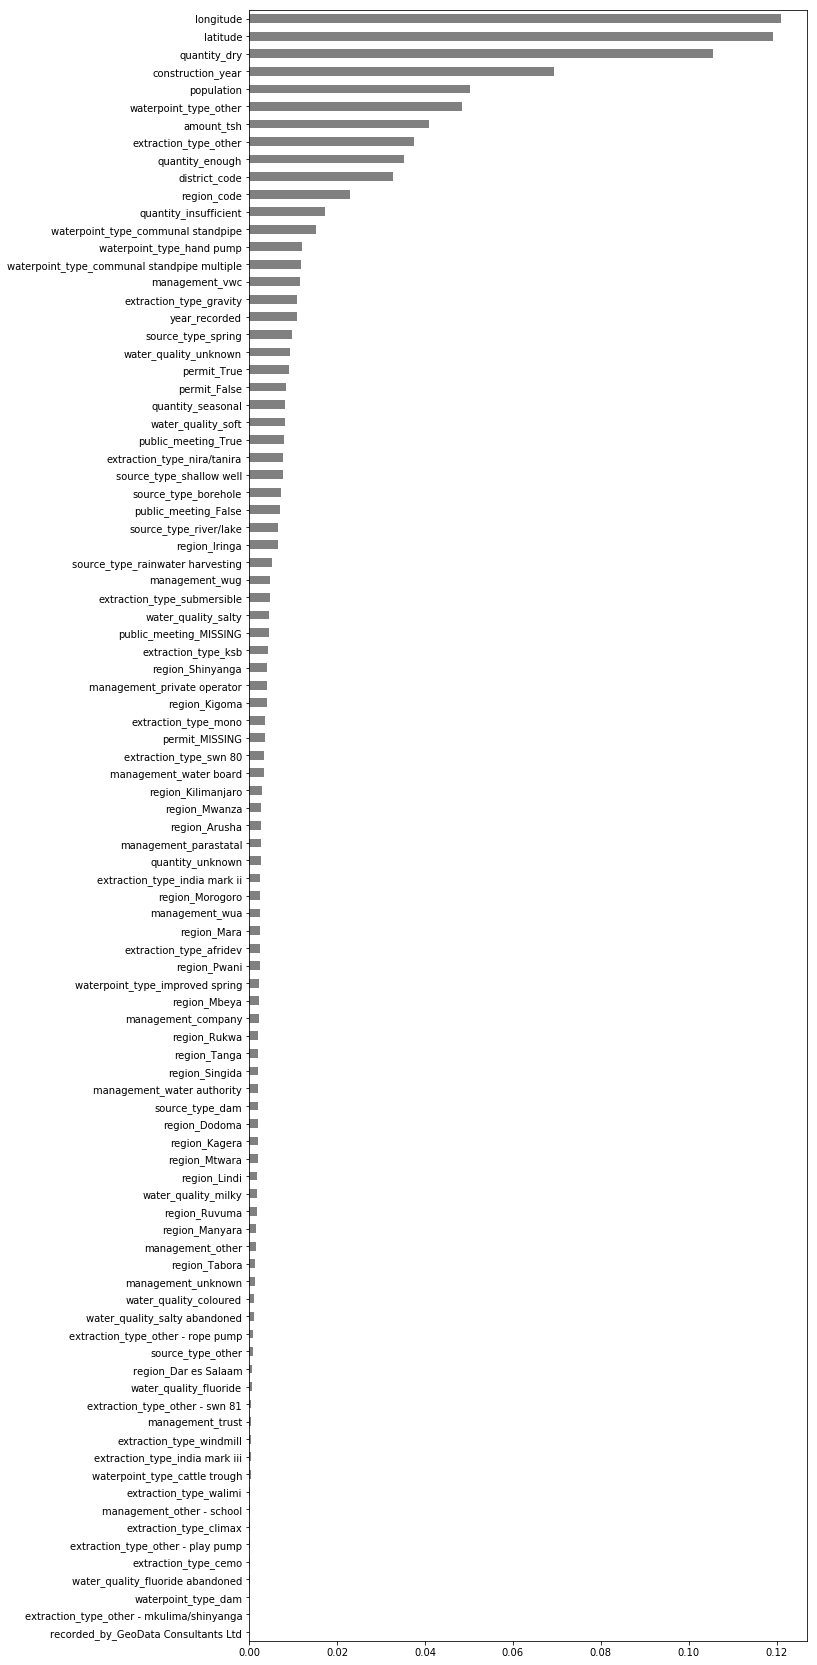

In [169]:
importances = pd.Series(model.feature_importances_, 
                        X_train_encoded.columns)

plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey');

In [0]:
from sklearn.ensemble import ExtraTreesClassifier

In [135]:
model = ExtraTreesClassifier(n_estimators = 400, random_state=42)
model.fit(X_train_encoded, y_train)
print('ExtraTreesClassifier')
print('Train Accuracy', model.score(X_train_encoded, y_train))
print('Validation Accuracy', model.score(X_val_encoded, y_val))

ExtraTreesClassifier
Train Accuracy 0.9953914141414142
Validation Accuracy 0.7902356902356902


In [0]:
y_pred = model.predict(X_test_scaled)

# Write submission csv file
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-02.csv', index=False)

In [0]:
importances = pd.Series(model.feature_importances_, 
                        X_train_encoded.columns)

In [0]:
new_features = importances.sort_values(ascending = False)
new_features = importances[:70]

In [0]:
new_features = list(new_features.index)

In [0]:
# Arrange data into X new_features matrix and y target vector 
X_train = train[new_features]
y_train = train[target]
X_val = val[new_features]
y_val = val[target]
X_test = test[new_features]

# Encoder: fit_transform on train, transform on val & test
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)